<a href="https://colab.research.google.com/github/freshmea/kuIotBigdataClass/blob/main/pythonData/overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
folder = "/content/"
loan_data = pd.read_csv(folder + "loan_data.csv.gz")
print(loan_data.head())
print(loan_data.info())

   Unnamed: 0       status  loan_amnt       term  annual_inc    dti  \
0           1  Charged Off       2500  60 months       30000   1.00   
1           2  Charged Off       5600  60 months       40000   5.55   
2           3  Charged Off       5375  60 months       15000  18.08   
3           4  Charged Off       9000  36 months       30000  10.08   
4           5  Charged Off      10000  36 months      100000   7.06   

   payment_inc_ratio  revol_bal  revol_util             purpose  ...  \
0            2.39320       1687         9.4                 car  ...   
1            4.57170       5210        32.6      small_business  ...   
2            9.71600       9279        36.5               other  ...   
3           12.21520      10452        91.7  debt_consolidation  ...   
4            3.90888      11997        55.5               other  ...   

  delinq_2yrs_zero  pub_rec_zero  open_acc  grade  outcome emp_length  \
0                1             1         3    4.8  default         

In [6]:
predictors = ["loan_amnt", "term", "annual_inc", "dti", "payment_inc_ratio", "revol_bal", "revol_util", "purpose", "delinq_2yrs_zero", "pub_rec_zero", "open_acc", "grade", "emp_length", "purpose_", "home_", "emp_len_", "borrower_score"]
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if out =='default' else 0 for out in loan_data[outcome]])

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=10000)

from xgboost import XGBClassifier
xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250,
                            max_depth=6, reg_lambda=0, learning_rate=0.3, subsample=1)
xgb_default.fit(train_X, train_y)
pred_default = xgb_default.predict(test_X)
error_default = abs(test_y - pred_default) > 0.5
print(f"error_default mean : {np.mean(error_default)}")
print(f"acc : {accuracy_score(test_y, pred_default)}")

error_default mean : 0.3586
acc : 0.6414


In [8]:
predictors = ["loan_amnt", "term", "annual_inc", "dti", "payment_inc_ratio", "revol_bal", "revol_util", "purpose", "delinq_2yrs_zero", "pub_rec_zero", "open_acc", "grade", "emp_length", "purpose_", "home_", "emp_len_", "borrower_score"]
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if out =='default' else 0 for out in loan_data[outcome]])

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=10000)

from xgboost import XGBClassifier
xgb_panalty = XGBClassifier(objective='binary:logistic', n_estimators=250,
                            max_depth=6, reg_lambda=1000, learning_rate=0.3, subsample=1)
xgb_panalty.fit(train_X, train_y)
pred_default = xgb_panalty.predict(test_X)
error_default = abs(test_y - pred_default) > 0.5
print(f"error_default mean : {np.mean(error_default)}")
print(f"acc : {accuracy_score(test_y, pred_default)}")

error_default mean : 0.3304
acc : 0.6696


In [13]:
results = []
for ntree_limit in range(1, 250):
  iteration_range = [1, ntree_limit + 1]
  train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
  train_panalty = xgb_panalty.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
  pred_default = xgb_default.predict_proba(test_X, iteration_range=iteration_range)[:, 1]
  pred_panalty = xgb_panalty.predict_proba(test_X, iteration_range=iteration_range)[:, 1]
  results.append({
      'iterations' : ntree_limit,
      'default train' : np.mean(abs(train_y - train_default) > 0.5),
      'panalty train' : np.mean(abs(train_y - train_panalty) > 0.5),
      'default test' : np.mean(abs(test_y - pred_default) > 0.5),
      'panalty test' : np.mean(abs(test_y - pred_panalty) > 0.5)
  })
results = pd.DataFrame(results)
results.head()

,iterations,default train,panalty train,default test,panalty test
0,1,0.338577,0.340784,0.3320,0.3532
1,2,0.339228,0.335069,0.3340,0.3457
2,3,0.339341,0.333314,0.3352,0.3435
3,4,0.335125,0.332918,0.3336,0.3420
4,5,0.333060,0.330825,0.3335,0.3412


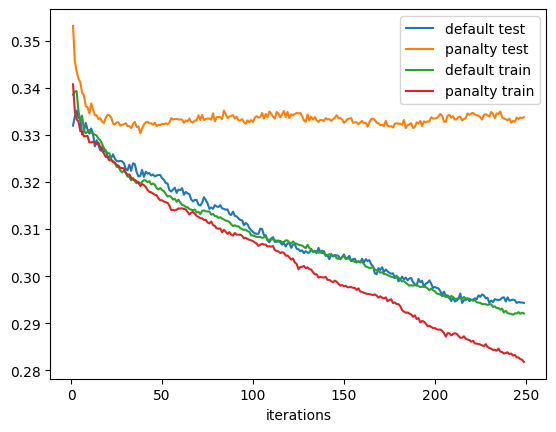

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
results.plot(x='iterations', y='default test', ax=ax)
results.plot(x='iterations', y='panalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='panalty train', ax=ax)
plt.show()